In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d vbookshelf/rice-leaf-diseases #veri setinin buraya yapıştır
! unzip /content/rice-leaf-diseases.zip

In [2]:
import pandas as pd
import numpy as np

from PIL import Image

import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dropout,Dense
from keras.models import Model
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.applications import ResNet152V2, ResNetRS50, VGG16 #feature maps
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense #yapay sinir ağı
from tensorflow.keras.models import Model

In [3]:
file_path='/content/rice_leaf_diseases'

In [4]:
pip install split_folders

In [5]:
import splitfolders
splitted_folder='/content/rice_leaf_diseases/splitted_folder'
def train_test_valid(train_size=0.6,test_size=0.2,val_size=0.2,images_folder=file_path,splitted_folder=splitted_folder):
  train_size = train_size
  test_size = test_size
  val_size = val_size
  input_folder = images_folder
  output_folder = splitted_folder
  splitfolders.ratio(input_folder,output_folder, seed = 1337, ratio = (train_size,test_size,val_size), group_prefix = None)
train_test_valid()

Copying files: 120 files [00:00, 1355.25 files/s]


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_file_path = '/content/rice_leaf_diseases/splitted_folder/train'
test_file_path =  '/content/rice_leaf_diseases/splitted_folder/test'
val_file_path =  '/content/rice_leaf_diseases/splitted_folder/val'

def data_pre_processing(valid_split = 0,input_size = (224, 224),image_color = 'rgb',batch_size = 32,shuffle=True):
  train_gen=ImageDataGenerator(rescale=1/255.0,validation_split=valid_split,fill_mode='nearest',rotation_range=40,horizontal_flip=True)
  validation_gen=ImageDataGenerator(rescale=1/255.0,validation_split=valid_split)
  test_gen=ImageDataGenerator(rescale=1/255.0)
  train_data=train_gen.flow_from_directory(directory=train_file_path,target_size=input_size,color_mode=image_color,
                                             batch_size=batch_size,shuffle=shuffle,class_mode='categorical')
  test_data=test_gen.flow_from_directory(directory=test_file_path,target_size=input_size,color_mode=image_color,
                                             batch_size=batch_size,shuffle=shuffle,class_mode='categorical')
  valid_data=validation_gen.flow_from_directory(directory=val_file_path,target_size=input_size,color_mode=image_color,
                                             batch_size=batch_size,shuffle=shuffle,class_mode='categorical')
  return train_data,test_data,valid_data #Bana geri döndüğünde yazdığım bu değerleri çıktı ver

train2,test2,validation2=data_pre_processing()

In [7]:
os.chdir('/content/rice_leaf_diseases/splitted_folder/')
os.listdir()

['test', 'train', 'val']

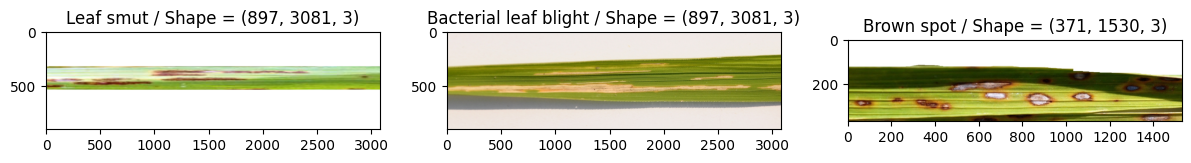

In [8]:
classes = os.listdir('train')
plt.figure(figsize=(25,10))
for i in enumerate(classes):
    pic = os.listdir('train/'+i[1])[0]
    image = Image.open('train/'+i[1]+'/'+pic)
    image = np.asarray(image)
    plt.subplot(2,5,i[0]+1)
    plt.title('{0} / Shape = {1}'.format(i[1], image.shape))
    plt.imshow(image)
plt.show()

In [ ]:
base_model = keras.applications.Xception(input_shape=(224,224,3), include_top=False, weights="imagenet")
for layers in base_model.layers[:140]:
      layers.trainable = False
for layers in base_model.layers[140:]:
      layers.trainable = True
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1000, activation='relu')(x)
pred = Dense(3, activation='softmax')(x)
model2 = Model(inputs=base_model.input, outputs=pred)
model2.summary()

In [ ]:
keras.utils.plot_model(
    model2,
    show_shapes=True,
    show_layer_activations=True,
    show_dtype=True,
    show_layer_names=True,
    show_trainable=True
)

In [22]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model2.fit(train2, batch_size=32, epochs=4, validation_data=validation2)

Epoch 1/4
3/3 [==============================] - 11s 3s/step - loss: 1.4386 - accuracy: 0.5278 - val_loss: 1.2796 - val_accuracy: 0.5417
Epoch 2/4
3/3 [==============================] - 2s 616ms/step - loss: 0.6717 - accuracy: 0.7361 - val_loss: 0.6420 - val_accuracy: 0.7917
Epoch 3/4
3/3 [==============================] - 2s 611ms/step - loss: 0.2871 - accuracy: 0.9028 - val_loss: 0.9664 - val_accuracy: 0.6250
Epoch 4/4
3/3 [==============================] - 2s 933ms/step - loss: 0.3389 - accuracy: 0.8889 - val_loss: 0.8237 - val_accuracy: 0.7500


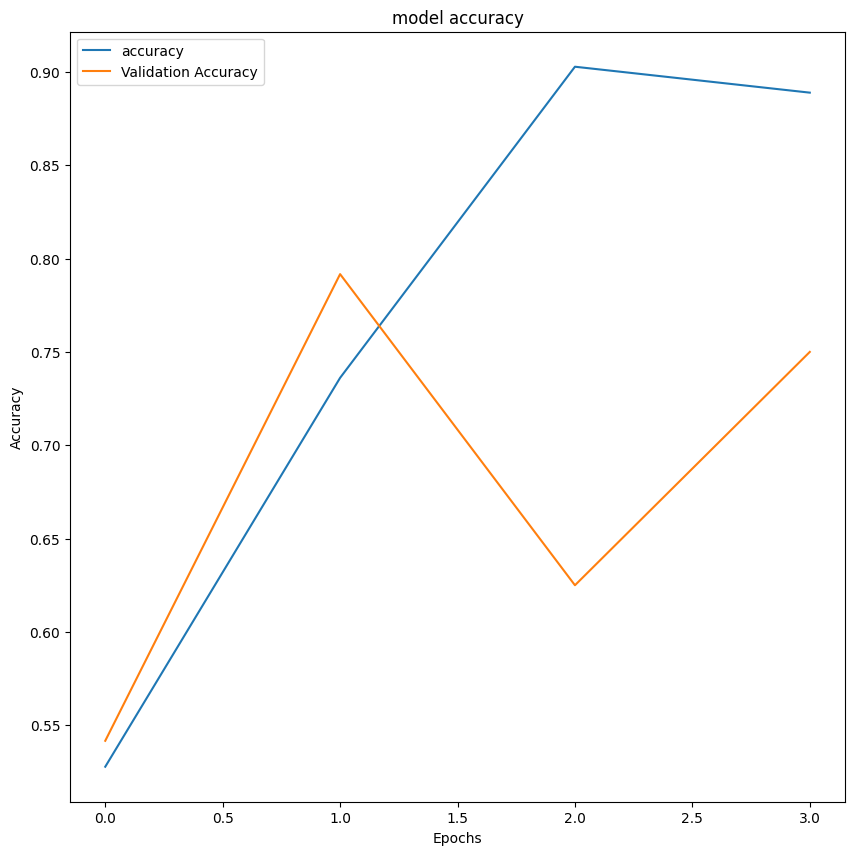

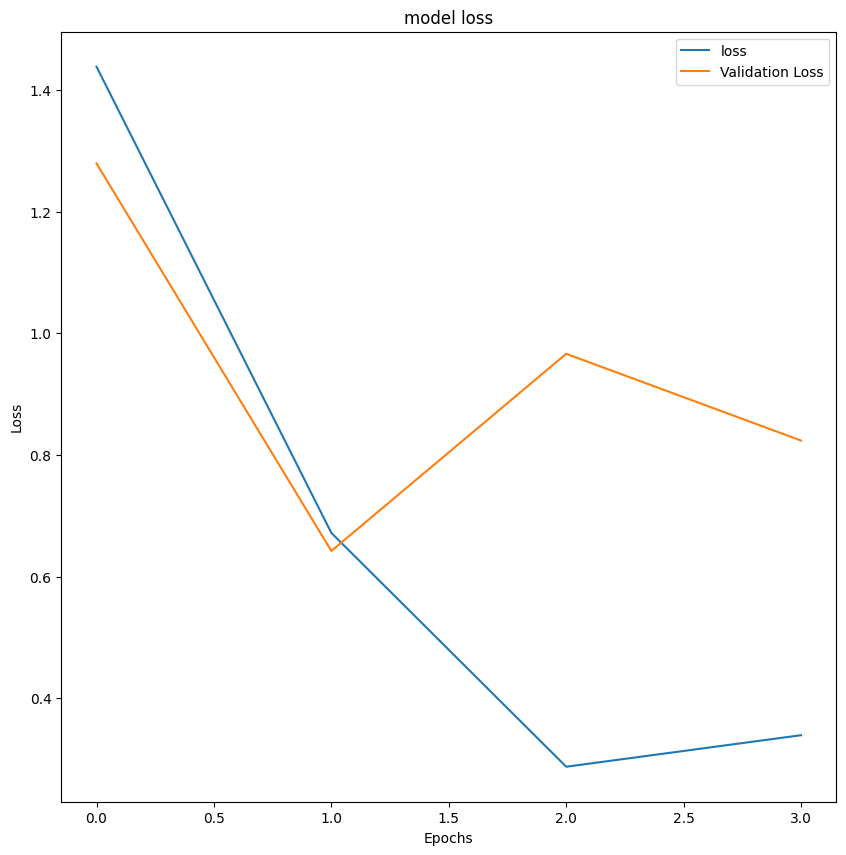

In [23]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["accuracy","Validation Accuracy"])
plt.show()

plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["loss","Validation Loss"])
plt.show()

In [ ]:
y_real=[]
all_pred=[]
count=0
for x,y in test2:
  predict=model2.predict(x)

  for i in predict:
    all_pred.append(np.argmax(i)+1)
  for i in y:
    i=np.argmax(i)+1
    y_real.append(i)

  if len(y_real)==len(test2.filepaths):
    break

In [25]:
target_names =[]
for key,value in test2.class_indices.items(): #Mevcut test datamızdaki sınıfların numarısı almış oluruz
  target_names.append(f'condition: {key}')

In [26]:
from sklearn import metrics
report=metrics.classification_report(y_real,all_pred,target_names=target_names)
conf_efficnet2=metrics.confusion_matrix(y_real,all_pred)

In [ ]:
report

'                                  precision    recall  f1-score   support\n\ncondition: Bacterial leaf blight       1.00      0.25      0.40         8\n           condition: Brown spot       0.00      0.00      0.00         8\n            condition: Leaf smut       0.18      0.38      0.24         8\n\n                        accuracy                           0.21        24\n                       macro avg       0.39      0.21      0.21        24\n                    weighted avg       0.39      0.21      0.21        24\n'

In [27]:
import itertools
def plot_confusion_matrix(cnf_matrix, numbers_type='numbers_and_percentage', class_names=target_names, title='Confusion matrix', cmap=plt.cm.Blues, file_name='confusionmatrix.png'):
    combined = True
    cnf_matrix_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = 0.8*cnf_matrix.max() / 1.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        if numbers_type == 'numbers_and_percentage':
            st1 = '{:.2f}%'.format(100 * cnf_matrix_normalized[i, j])
            st2 = '({:2d})'.format(cnf_matrix[i, j])
            plt.text(j, i, st1+st2,
                     horizontalalignment="center", verticalalignment='bottom',
                     color="white" if cnf_matrix[i, j] > thresh else "black")

        elif numbers_type == 'percentage':
            fmt = '.2f'
            plt.text(j, i, format(cnf_matrix_normalized[i, j], fmt),
                     horizontalalignment="center", verticalalignment='bottom',
                     color="white" if cnf_matrix[i, j] > thresh else "black")
        else:
            fmt = 'd'
            plt.text(j, i, format(cnf_matrix[i, j], fmt),
                     horizontalalignment="center", verticalalignment='bottom',
                     color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(file_name)

    return

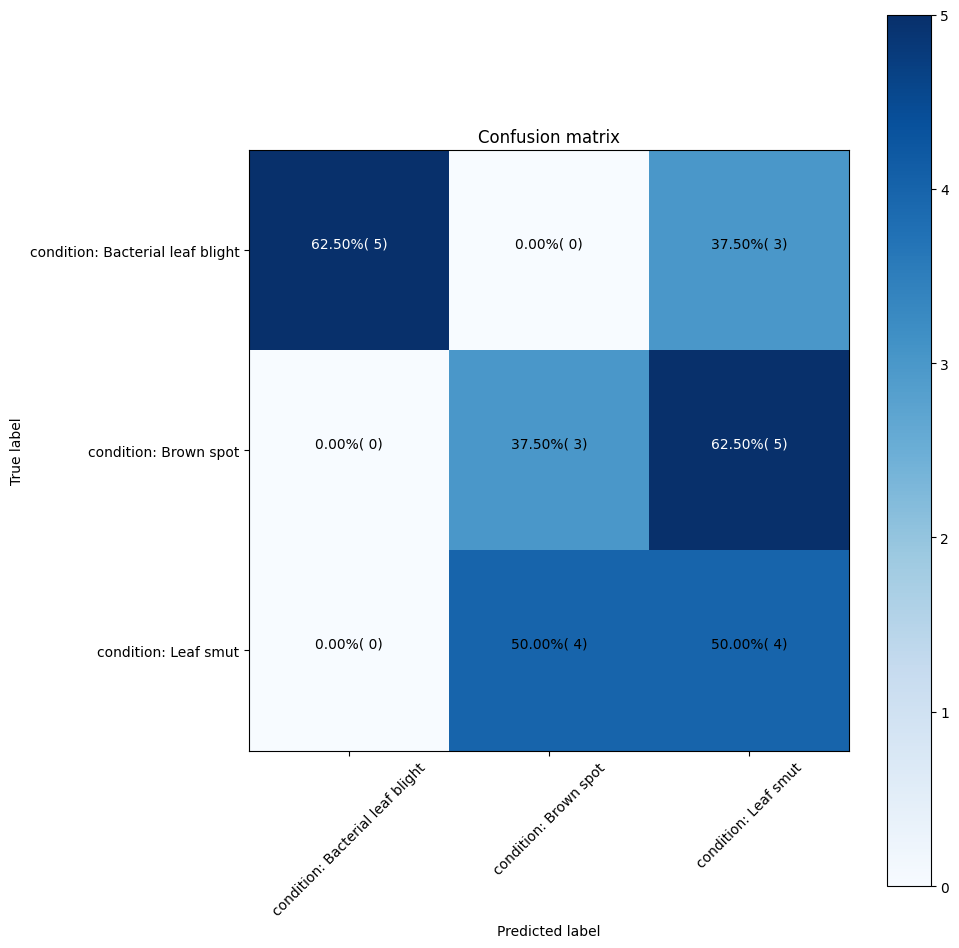

In [28]:
plot_confusion_matrix(conf_efficnet2)